In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 7, 7, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(3931, 25088)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 26.2min


[CV] .............. C=0.01, gamma=1e-06, score=0.879135, total=14.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.896947, total=15.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.917303, total=15.2min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.610687, total=17.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.636132, total=17.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.629771, total=17.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.637405, total=17.8min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 32.0min


[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total=17.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total=18.0min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=18.1min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total=18.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=18.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=18.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=18.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 32.9min


[CV] .............. C=0.01, gamma=0.001, score=0.505718, total=17.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.505089, total=17.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.505089, total=17.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.505089, total=17.2min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.505089, total=17.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505718, total=16.9min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 62.6min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505089, total=17.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total=17.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=17.0min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 75.2min


[CV] ............... C=0.1, gamma=1e-06, score=0.918575, total= 7.0min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.922490, total= 7.1min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.941476, total= 7.3min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.902036, total= 9.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.912325, total= 9.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.907125, total= 9.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.926209, total= 9.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 91.3min


[CV] ............... C=0.1, gamma=1e-05, score=0.620865, total=15.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.605598, total=15.9min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.603053, total=16.0min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.515883, total=16.6min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-08, score=0.702290, total=16.9min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.517812, total=16.5min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-08, score=0.740458, total=17.0min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 110.9min


[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.505089, total=17.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.505089, total=16.6min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.505089, total=16.6min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.505089, total=16.5min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.505718, total=17.0min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.505089, total=17.1min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.944091, total= 5.2min
[CV] C

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 124.1min


[CV] ................ C=0.1, gamma=10.0, score=0.505718, total=16.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.942748, total= 4.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.936387, total= 4.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.902036, total= 9.1min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.959288, total= 5.2min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.926209, total= 9.2min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.908397, total= 9.1min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 137.8min


[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=17.1min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.831004, total=15.8min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.839695, total=15.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.857506, total=15.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.848601, total=15.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.824427, total=16.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.592122, total=17.1min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 161.4min


[CV] ................ C=1.0, gamma=0.01, score=0.522901, total=16.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.516539, total=17.2min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.515883, total=16.2min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.511450, total=16.2min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.944091, total= 5.1min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.941476, total= 5.0min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.958015, total= 5.2min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 178.7min


[CV] .............. C=10.0, gamma=1e-06, score=0.965649, total= 6.0min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.960560, total= 6.1min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.512723, total=16.4min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.514612, total=16.4min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.511450, total=16.5min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ................. C=1.0, gamma=1.0, score=0.512723, total=16.6min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ................. C=1.0, gamma=1.0, score=0.508906, total=17.0min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 201.4min


[CV] ............. C=10.0, gamma=0.0001, score=0.610687, total=16.5min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.545802, total=16.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.614504, total=17.1min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.549618, total=16.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.564885, total=16.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.545108, total=17.0min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.554707, total=16.9min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 218.1min


[CV] ................ C=10.0, gamma=0.1, score=0.510178, total=16.8min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.969466, total= 3.9min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.959288, total= 3.7min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-07, score=0.977099, total= 3.9min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-07, score=0.965649, total= 3.8min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=0.1, score=0.512723, total=16.3min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-06, score=0.978399, total= 5.8min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 247.0min


[CV] ............. C=100.0, gamma=1e-05, score=0.875318, total=16.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.862595, total=16.5min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.832061, total=17.7min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.597205, total=16.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.618321, total=16.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.615776, total=16.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.610687, total=16.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 265.8min


[CV] ............ C=1000.0, gamma=1e-08, score=0.960560, total= 3.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.975858, total= 3.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.955471, total= 3.8min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.966921, total= 4.0min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.973282, total= 3.9min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.968193, total= 3.9min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ............... C=100.0, gamma=0.1, score=0.513995, total=16.5min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

In [16]:
top_model.cv_results_

{'mean_fit_time': array([ 870.6092072 ,  863.49479241,  717.70173283,  870.38112278,
         859.76335168,  824.99803324,  822.06840668,  821.07088184,
         817.50761395,  811.04218264,  799.72566819,  454.07395024,
         340.58325801,  766.77177258,  787.01488104,  826.88351293,
         802.63657603,  803.24086738,  799.24186044,  796.15974698,
         435.52460737,  244.92369943,  271.97749262,  769.97867103,
         809.69303617,  818.25001483,  797.34247184,  791.42950082,
         795.33234954,  803.00929303,  244.84415197,  183.30772438,
         293.85327945,  815.16633902,  802.18482018,  801.05337634,
         794.29390507,  793.64837503,  802.82232261,  791.04415979,
         178.29059381,  185.28973122,  286.81874032,  815.93906298,
         783.33359551,  808.26620226,  819.97044692,  791.17389479,
         802.57161036,  796.67127938,  189.73259001,  187.81674581,
         290.02527061,  831.20929861,  805.88575716,  809.81862102,
         801.86942744,  793.321

In [17]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.63165, std: 0.01144, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.89392, std: 0.01307, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.73340, std: 0.01645, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.91198, std: 0.00806, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.92470, std: 0.00849, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 9.9999999999999995e-08} - score: 0.9718


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


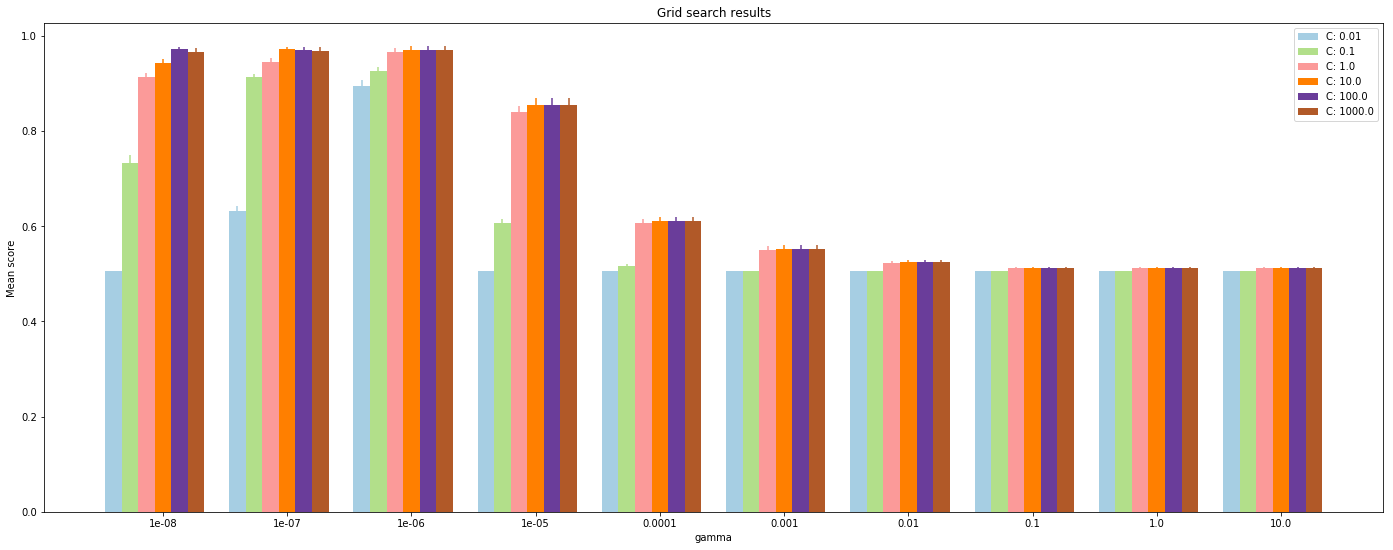

In [19]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()